In [1]:
#importing all libraries
import geopandas as geo
import pandas as pd
import psycopg
from bs4 import BeautifulSoup as BS
import requests as req
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#accessing the NCDC website
url = 'https://covid19.ncdc.gov.ng/'

page = req.get(url)

soup = BS(page.text, 'html')

In [3]:
table = soup.find('table')

In [4]:
table_columns = table.find_all('th')

In [5]:
table_column = [column.text.strip() for column in table_columns]

In [6]:
df = pd.DataFrame(columns = table_column)

In [7]:
column_data = table.find_all('tr')

In [8]:
for row in column_data[1:]:
  row_data = row.find_all('td')
  ind_row_data = [data.text.strip() for data in row_data]
  #loc -- location/index
  length = len(df)
  df.loc[length] = ind_row_data

In [9]:
df

,States Affected,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths
0,Lagos,"104,286","1,143","102,372",771
1,FCT,"29,535",9,"29,277",249
2,Rivers,"18,112",-3,"17,960",155
3,Kaduna,"11,675",3,"11,583",89
4,Plateau,"10,365",4,"10,286",75
5,Oyo,"10,352",0,"10,150",202
6,Edo,"7,928",0,"7,606",322
7,Delta,"5,858",576,"5,170",112
8,Ogun,"5,810",11,"5,717",82
9,Kano,"5,429",11,"5,291",127


In [10]:
def connect_to_database():
    conn = psycopg.connect("host=127.0.0.1 dbname=covid19 user=postgres password=victoria1234")
    cur = conn.cursor()
    conn.commit()

    return cur,conn

In [11]:
cur, conn = connect_to_database()

In [12]:
covid19_data = ("""CREATE TABLE IF NOT EXISTS covid19_data(
states VARCHAR,
lab_confirmed_cases VARCHAR,
on_admission_cases VARCHAR,
num_discharged VARCHAR,
num_deaths VARCHAR
) """)

In [13]:
cur.execute(covid19_data)
conn.commit()

In [14]:
covid19_data_insert = ("""INSERT INTO covid19_data(
states,
lab_confirmed_cases,
on_admission_cases,
num_discharged,
num_deaths)
VALUES (%s, %s, %s, %s, %s)
""")

In [15]:
for i, row in df.iterrows():
    cur.execute(covid19_data_insert, list(row))
conn.commit()

In [16]:
#getting the data back

data = """SELECT * FROM covid19_data"""

In [17]:
cur.execute(data)
conn.commit()

In [18]:
data_covid = cur.fetchall()

In [19]:
new_df = pd.DataFrame(data_covid, columns=["states", "lab_confirmed_cases", "on_admission_cases", "num_discharged", "num_deaths"])

In [20]:
conn.close()

In [21]:
new_df.head()

,states,lab_confirmed_cases,on_admission_cases,num_discharged,num_deaths
0,Lagos,"104,286","1,143","102,372",771
1,FCT,"29,535",9,"29,277",249
2,Rivers,"18,112",-3,"17,960",155
3,Kaduna,"11,675",3,"11,583",89
4,Plateau,"10,365",4,"10,286",75


In [22]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   states               37 non-null     object
 1   lab_confirmed_cases  37 non-null     object
 2   on_admission_cases   37 non-null     object
 3   num_discharged       37 non-null     object
 4   num_deaths           37 non-null     object
dtypes: object(5)
memory usage: 1.6+ KB


### Data Cleaning and Analysis (TRANSFORMATION)

###### Converting the columns to the correct datatypes

In [23]:
# Remove the comma from the columns
new_df['num_discharged'] = new_df['num_discharged'].str.replace(',', '')
new_df['on_admission_cases'] = new_df['on_admission_cases'].str.replace(',', '')
new_df['lab_confirmed_cases'] = new_df['lab_confirmed_cases'].str.replace(',', '')


# Convert the columns to int
new_df['num_discharged'] = pd.to_numeric(new_df['num_discharged'])
new_df['on_admission_cases'] = pd.to_numeric(new_df['on_admission_cases'])
new_df['lab_confirmed_cases'] = pd.to_numeric(new_df['lab_confirmed_cases'])
new_df['num_deaths'] = pd.to_numeric(new_df['num_deaths'])

In [24]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   states               37 non-null     object
 1   lab_confirmed_cases  37 non-null     int64 
 2   on_admission_cases   37 non-null     int64 
 3   num_discharged       37 non-null     int64 
 4   num_deaths           37 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.6+ KB


#### The Dataset consist of 5 columns namely:

##### States: Contains all the states in Nigeria
##### lab_confirmed_cases: Contains all the Covid 19 cases confirmed in each states
##### on_admission_cases: Contains all the Covid 19 patient that are still admitted in each states
##### num_discharged: Contains all the covid 19 patients that has been discharged already
##### num_deaths: Contains all the patients that died due to Covid 19 

In [25]:
Total_states = new_df['states'].nunique()
print('Total number of States in Nigeria:', Total_states)

Total number of States in Nigeria: 37


In [26]:
Total_Covid_cases = new_df['lab_confirmed_cases'].sum()
print('Total number of Covid 19 Lab. Confirmed Cases in Nigeria:', Total_Covid_cases)

Total number of Covid 19 Lab. Confirmed Cases in Nigeria: 266675


In [27]:
Total_Death = new_df['num_deaths'].sum()

print('Total number of Deaths due to Covid 19 in Nigeria:', Total_Death)

Total number of Deaths due to Covid 19 in Nigeria: 3155


In [28]:
Total_Discharged = new_df['num_discharged'].sum()

print('Total number of Covid 19 discharged cases in Nigeria:', Total_Discharged)

Total number of Covid 19 discharged cases in Nigeria: 259953


In [29]:
On_Admission = new_df['on_admission_cases'].sum()

print(On_Admission, 'patients are still admitted due to Covid 19 in Nigeria')

3567 patients are still admitted due to Covid 19 in Nigeria


In [30]:
new_df.head()

,states,lab_confirmed_cases,on_admission_cases,num_discharged,num_deaths
0,Lagos,104286,1143,102372,771
1,FCT,29535,9,29277,249
2,Rivers,18112,-3,17960,155
3,Kaduna,11675,3,11583,89
4,Plateau,10365,4,10286,75


In [31]:
new_df['death_rate(%)'] = round(((new_df['num_deaths'] / new_df['lab_confirmed_cases']) * 100),2)

new_df.head()

,states,lab_confirmed_cases,on_admission_cases,num_discharged,num_deaths,death_rate(%)
0,Lagos,104286,1143,102372,771,0.74
1,FCT,29535,9,29277,249,0.84
2,Rivers,18112,-3,17960,155,0.86
3,Kaduna,11675,3,11583,89,0.76
4,Plateau,10365,4,10286,75,0.72


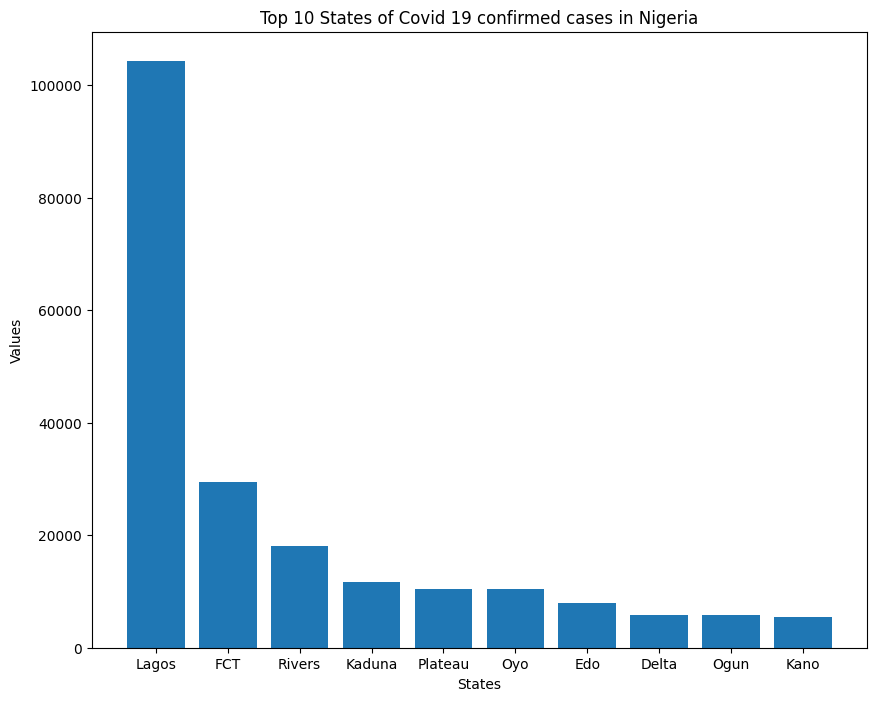

In [32]:
fig = plt.subplots(figsize=(10, 8))

top_10_states = new_df.states[:10]
top_10_confirmed_cases = new_df.lab_confirmed_cases[:10]
#colors = np.random.rand(10)
plt.bar(top_10_states, top_10_confirmed_cases)
plt.title("Top 10 States of Covid 19 confirmed cases in Nigeria")
plt.xlabel("States")
plt.ylabel("Values")
plt.savefig('confirmed_case.png')
plt.show()


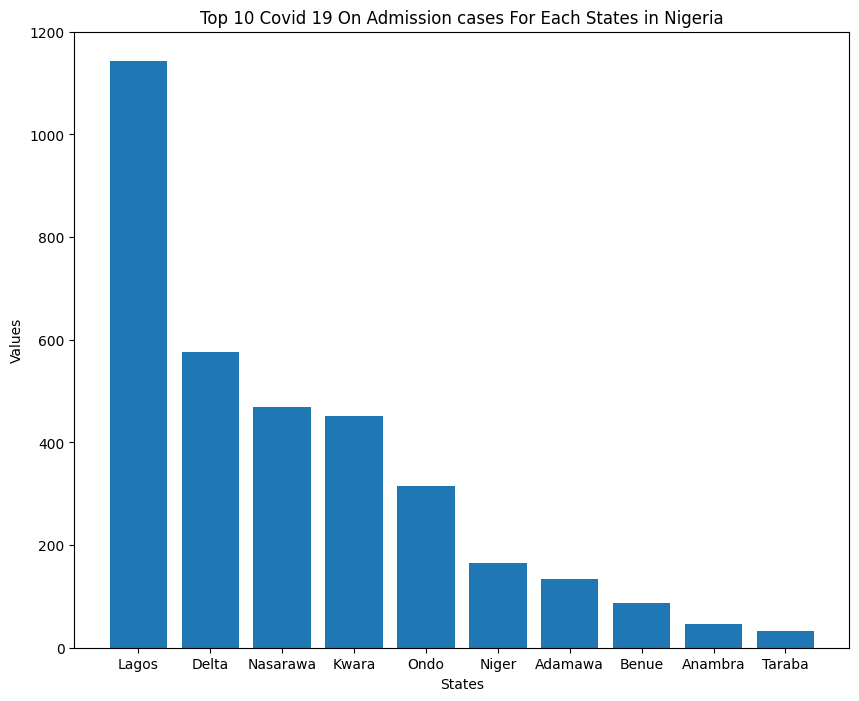

In [33]:
fig = plt.subplots(figsize=(10, 8))
at = new_df.sort_values(by=['on_admission_cases'], ascending=False)
top_10_states = at.states[:10]
top_10_confirmed_cases = at.on_admission_cases[:10]
#colors = np.random.rand(10)
plt.bar(top_10_states, top_10_confirmed_cases)
plt.title("Top 10 Covid 19 On Admission cases For Each States in Nigeria")
plt.xlabel("States")
plt.ylabel("Values")
plt.savefig('admission.png')
plt.show()


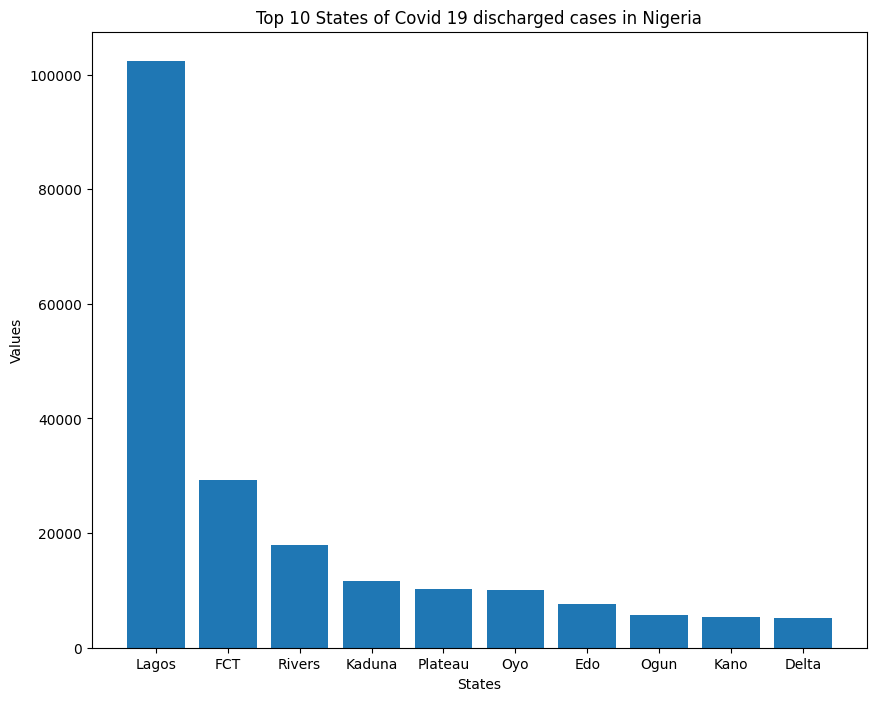

In [34]:
fig = plt.subplots(figsize=(10, 8))
dat = new_df.sort_values(by=['num_discharged'], ascending=False)
top_10_states = dat.states[:10]
top_10_discharged_cases = dat.num_discharged[:10]
#colors = np.random.rand(10)
plt.bar(top_10_states, top_10_discharged_cases)
plt.title("Top 10 States of Covid 19 discharged cases in Nigeria")
plt.xlabel("States")
plt.ylabel("Values")
plt.savefig('discharged.png')
plt.show()


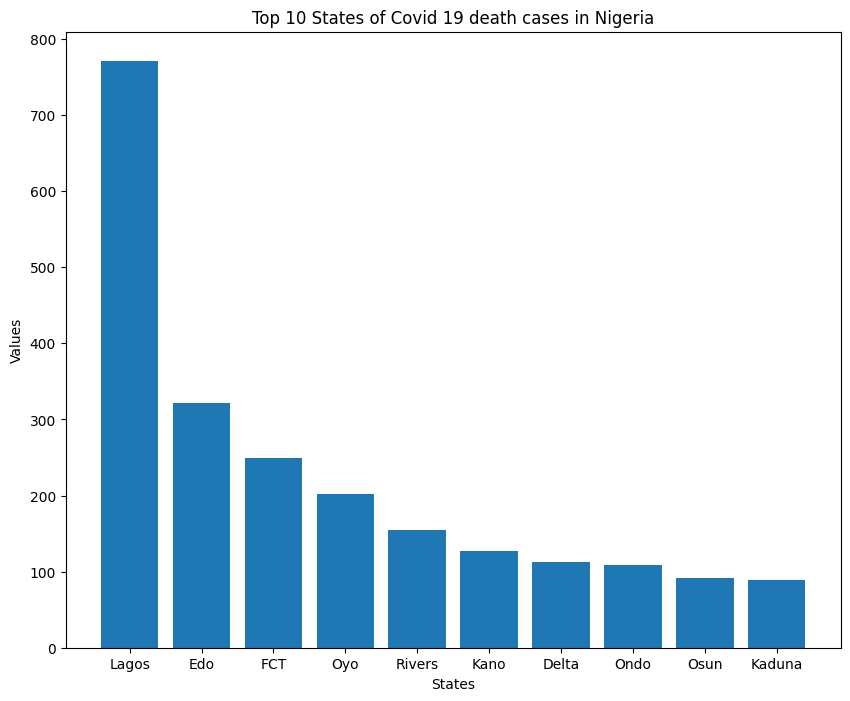

In [35]:
fig = plt.subplots(figsize=(10, 8))
data = new_df.sort_values(by=['num_deaths'], ascending=False)
top_10_states = data.states[:10]
top_10_confirmed_cases = data.num_deaths[:10]
#colors = np.random.rand(10)
plt.bar(top_10_states, top_10_confirmed_cases)
plt.title("Top 10 States of Covid 19 death cases in Nigeria")
plt.xlabel("States")
plt.ylabel("Values")
plt.savefig('death.png')
plt.show()


In [64]:
new_dataset = dataset[:5]

new_dataset

,states,lab_confirmed_cases,on_admission_cases,num_discharged,num_deaths,death_rate(%)
36,Kogi,5,0,3,2,40.00
6,Edo,7928,0,7606,322,4.06
31,Sokoto,822,0,794,28,3.41
34,Kebbi,480,10,454,16,3.33
28,Adamawa,1312,134,1140,38,2.90


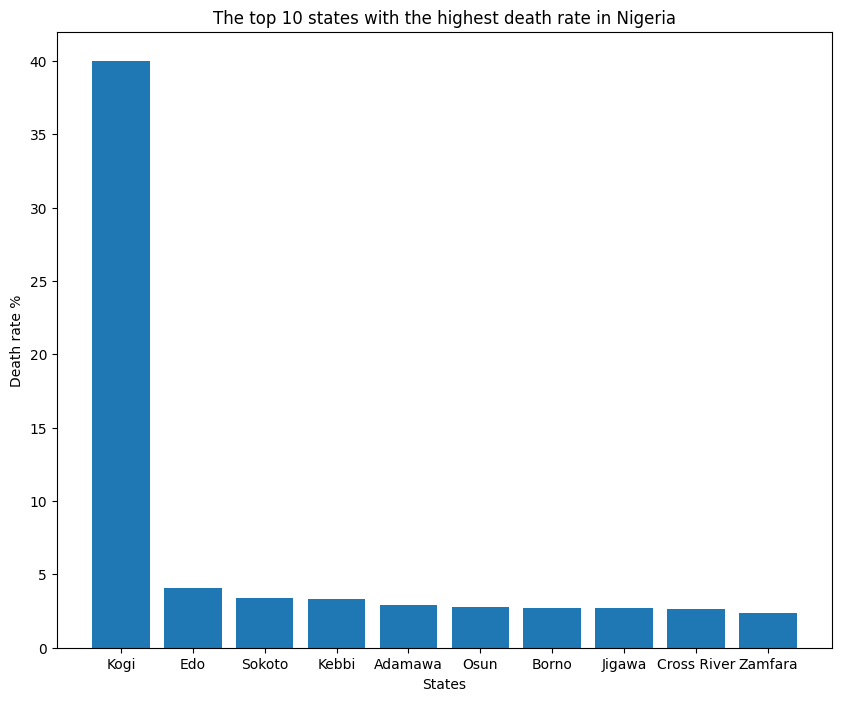

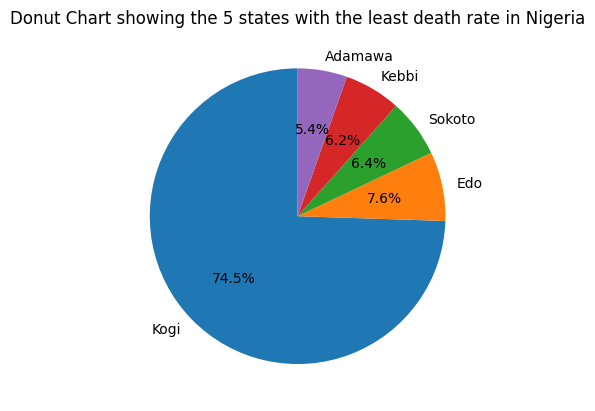

In [73]:
dataset = new_df.sort_values(by = ['death_rate(%)'], ascending=False)

new_dataset = dataset[:10]
# Pie chart
colors = ['red', 'green', 'blue', 'yellow', 'orange']
fig = plt.subplots(figsize=(10, 8))
plt.bar( new_dataset['states'], new_dataset['death_rate(%)'])
plt.title('The top 10 states with the highest death rate in Nigeria')
plt.xlabel("States")
plt.ylabel("Death rate %")
plt.show()
plt.savefig('death_rate.png')
# Donut chart
down_dataset = dataset[:5]
plt.pie(down_dataset['death_rate(%)'], labels=down_dataset['states'], autopct='%1.1f%%', startangle=90)
plt.title('Donut Chart showing the 5 states with the least death rate in Nigeria')
plt.show()


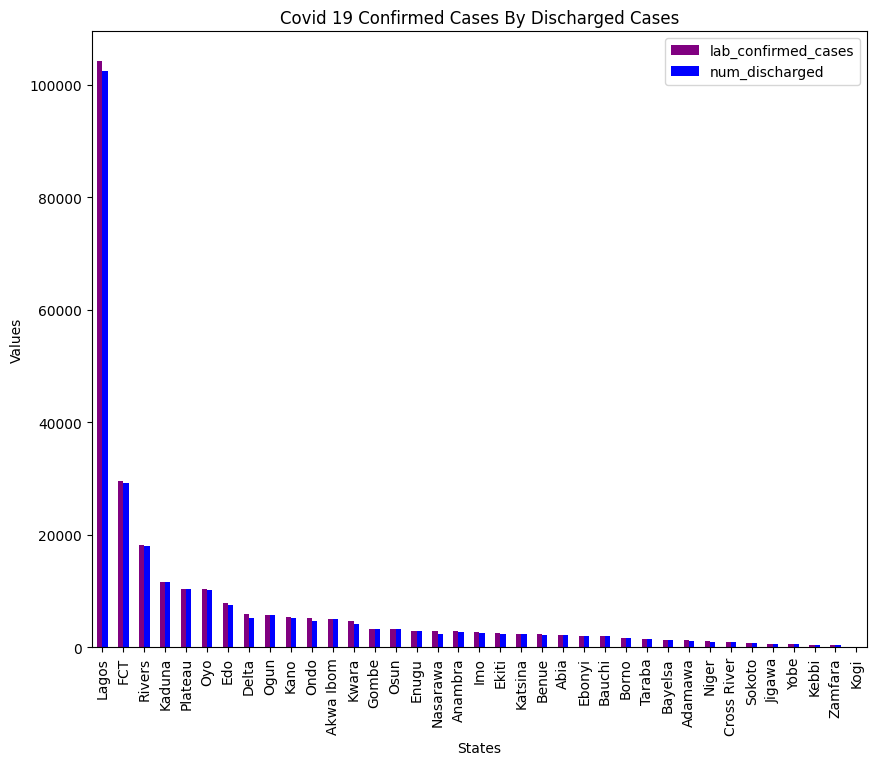

In [37]:
# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 8))
df = new_df[['states','lab_confirmed_cases', 'num_discharged']]
df = df.set_index("states")

df.plot(kind="bar", ax=ax, color = ['purple','blue'])

# Add a title, x-axis label, and y-axis label to the chart
ax.set_title("Covid 19 Confirmed Cases By Discharged Cases")
ax.set_xlabel("States")
ax.set_ylabel("Values")

# Add a legend to the chart
ax.legend()

# Display the chart
plt.show()


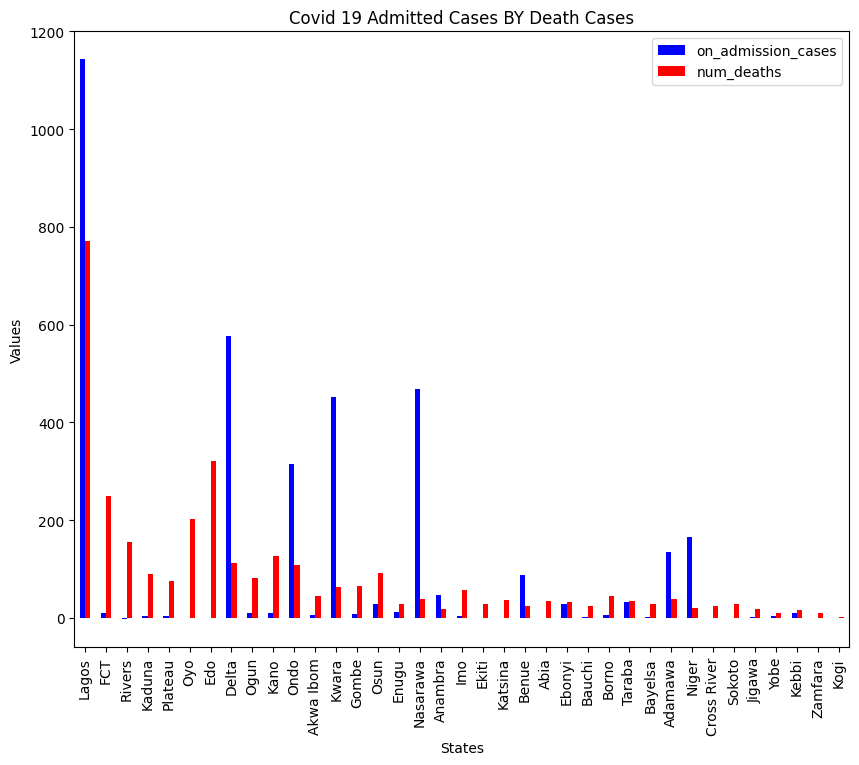

In [38]:
# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 8))
df2 = new_df[['states','on_admission_cases', 'num_deaths']]

df2 = df2.set_index("states")

df2.plot(kind="bar", ax=ax, color = ['blue', 'red'])

# Add a title, x-axis label, and y-axis label to the chart
ax.set_title("Covid 19 Admitted Cases BY Death Cases")
ax.set_xlabel("States")
ax.set_ylabel("Values")

# Add a legend to the chart
ax.legend()

plt.savefig('admit_death.png')
# Display the chart
plt.show()


> The dataset containing the geographical information for each states will be added to the covid 19 data

In [39]:
# Load the shapefile
shapefile_path = 'NGA_adm1.shp'
gdf = geo.read_file(shapefile_path)

In [40]:
gdf = gdf.drop(35)


In [41]:
gdf.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,163,NGA,Nigeria,1,Abia,State,State,None,None,"POLYGON ((7.50801 6.00969, 7.51943 6.00188, 7...."
1,163,NGA,Nigeria,2,Adamawa,State,State,None,None,"POLYGON ((13.72386 10.91173, 13.72138 10.90605..."
2,163,NGA,Nigeria,3,Akwa Ibom,State,State,None,None,"MULTIPOLYGON (((7.61069 4.47292, 7.61069 4.472..."
3,163,NGA,Nigeria,4,Anambra,State,State,None,None,"POLYGON ((6.91518 6.71104, 6.92614 6.70848, 6...."
4,163,NGA,Nigeria,5,Bauchi,State,State,None,None,"POLYGON ((10.73445 12.40430, 10.75293 12.35778..."


In [42]:
geodata = gdf[['NAME_1','geometry']]

In [43]:
geodata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 37 entries, 0 to 37
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NAME_1    37 non-null     object  
 1   geometry  37 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 888.0+ bytes


In [44]:
geodata = geodata.rename(columns={'NAME_1': 'states'})

In [45]:
geodata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 37 entries, 0 to 37
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   states    37 non-null     object  
 1   geometry  37 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 888.0+ bytes


In [46]:
geodata

,states,geometry
0,Abia,"POLYGON ((7.50801 6.00969, 7.51943 6.00188, 7...."
1,Adamawa,"POLYGON ((13.72386 10.91173, 13.72138 10.90605..."
2,Akwa Ibom,"MULTIPOLYGON (((7.61069 4.47292, 7.61069 4.472..."
3,Anambra,"POLYGON ((6.91518 6.71104, 6.92614 6.70848, 6...."
4,Bauchi,"POLYGON ((10.73445 12.40430, 10.75293 12.35778..."
5,Bayelsa,"MULTIPOLYGON (((6.44042 4.30875, 6.44042 4.307..."
6,Benue,"POLYGON ((8.86972 8.04525, 8.91494 8.04355, 8...."
7,Borno,"POLYGON ((13.36041 13.66980, 13.36403 13.65615..."
8,Cross River,"POLYGON ((8.98120 6.73874, 8.97962 6.72653, 8...."
9,Delta,"MULTIPOLYGON (((5.39153 5.30514, 5.39153 5.304..."


In [47]:
geodata.loc[14, 'states'] = 'FCT'
geodata.loc[25, 'states'] = 'Nasarawa'

In [48]:
# Merge the shapefile and DataFrame
merged_data = geodata.merge(new_df, on='states', how='left')

In [49]:
merged_data

,states,geometry,lab_confirmed_cases,on_admission_cases,num_discharged,num_deaths,death_rate(%)
0,Abia,"POLYGON ((7.50801 6.00969, 7.51943 6.00188, 7....",2263,0,2229,34,1.50
1,Adamawa,"POLYGON ((13.72386 10.91173, 13.72138 10.90605...",1312,134,1140,38,2.90
2,Akwa Ibom,"MULTIPOLYGON (((7.61069 4.47292, 7.61069 4.472...",5010,6,4960,44,0.88
3,Anambra,"POLYGON ((6.91518 6.71104, 6.92614 6.70848, 6....",2825,46,2760,19,0.67
4,Bauchi,"POLYGON ((10.73445 12.40430, 10.75293 12.35778...",2028,2,2002,24,1.18
5,Bayelsa,"MULTIPOLYGON (((6.44042 4.30875, 6.44042 4.307...",1373,2,1343,28,2.04
6,Benue,"POLYGON ((8.86972 8.04525, 8.91494 8.04355, 8....",2317,88,2204,25,1.08
7,Borno,"POLYGON ((13.36041 13.66980, 13.36403 13.65615...",1629,5,1580,44,2.70
8,Cross River,"POLYGON ((8.98120 6.73874, 8.97962 6.72653, 8....",947,0,922,25,2.64
9,Delta,"MULTIPOLYGON (((5.39153 5.30514, 5.39153 5.304...",5858,576,5170,112,1.91


In [50]:
# Define the projected CRS (e.g., UTM zone for Nigeria)
projected_crs = "EPSG:32633"  # Replace with the appropriate UTM zone for Nigeria

# Reproject the GeoDataFrame to the projected CRS
merged_data = merged_data.to_crs(projected_crs)


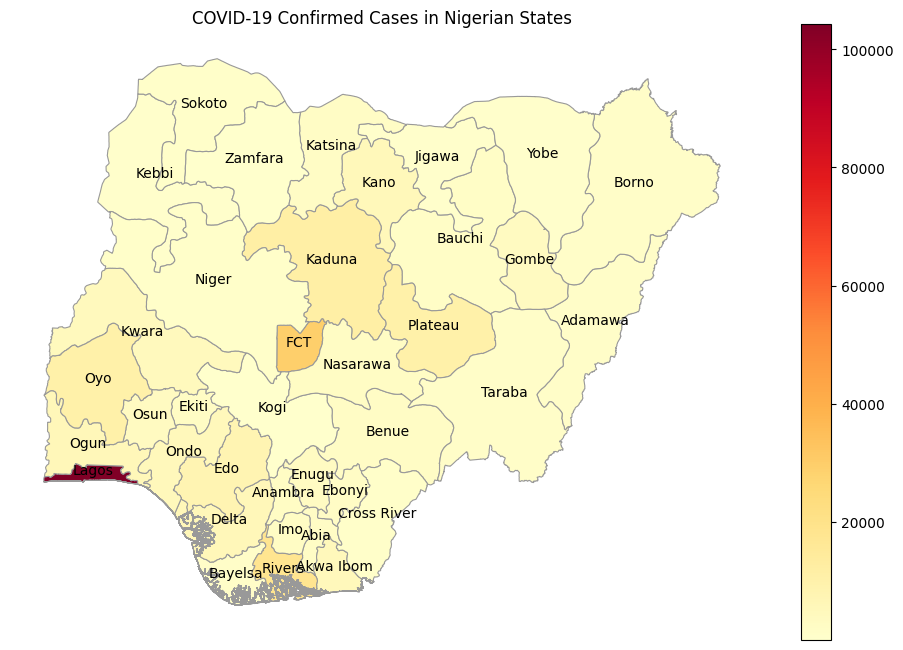

In [51]:
# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Choose a colormap for color fading
colormap = 'YlOrRd'  # You can choose a different colormap

# Plot the data with color fading
merged_data.plot(column='lab_confirmed_cases', cmap=colormap, linewidth=0.8, ax=ax, edgecolor='0.6', legend=True)

# Add labels to the map
for x, y, label in zip(merged_data.geometry.centroid.x, merged_data.geometry.centroid.y, merged_data['states']):
    ax.text(x, y, label,fontsize=10, ha='center')

# Set a title and customize the legend
ax.set_title('COVID-19 Confirmed Cases in Nigerian States')
ax.axis('off')  # Turn off axis

plt.savefig('map.png')
# Display the plot
plt.show()


In [52]:
import shapely.geometry

# Get the geometry objects from the GeoSeries
geometries = merged_data["geometry"]

# Convert the geometry objects to a list of WKT strings
wkt_strings = [geometry.wkt for geometry in geometries]

# Add the WKT strings to the merged_data DataFrame
merged_data["coordinate"] = wkt_strings


In [53]:
merged_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   states               37 non-null     object  
 1   geometry             37 non-null     geometry
 2   lab_confirmed_cases  37 non-null     int64   
 3   on_admission_cases   37 non-null     int64   
 4   num_discharged       37 non-null     int64   
 5   num_deaths           37 non-null     int64   
 6   death_rate(%)        37 non-null     float64 
 7   coordinate           37 non-null     object  
dtypes: float64(1), geometry(1), int64(4), object(2)
memory usage: 2.4+ KB


In [54]:
fact_data = merged_data.drop(columns = 'geometry')

In [55]:
fact_data.head()

,states,lab_confirmed_cases,on_admission_cases,num_discharged,num_deaths,death_rate(%),coordinate
0,Abia,2263,0,2229,34,1.50,POLYGON ((-331455.55842738727 669991.735057538...
1,Adamawa,1312,134,1140,38,2.90,POLYGON ((360537.5517507945 1206513.2094840484...
2,Akwa Ibom,5010,6,4960,44,0.88,MULTIPOLYGON (((-322026.3286814919 498553.2296...
3,Anambra,2825,46,2760,19,0.67,POLYGON ((-396432.15423566743 749233.589396372...
4,Bauchi,2028,2,2002,24,1.18,POLYGON ((35967.380645610276 1374976.868342708...


In [56]:
cur, conn = connect_to_database()

In [57]:
covid19_data_nigeria = ("""CREATE TABLE IF NOT EXISTS covid19_nigeria(
states VARCHAR,
lab_confirmed_cases VARCHAR,
on_admission_cases VARCHAR,
num_discharged VARCHAR,
num_deaths VARCHAR,
death_rate VARCHAR,
states_coordinate VARCHAR
) """)

In [58]:
cur.execute(covid19_data_nigeria)
conn.commit()

In [59]:
covid19_nigeria_insert = ("""INSERT INTO covid19_nigeria(
states,
lab_confirmed_cases,
on_admission_cases,
num_discharged,
num_deaths,
death_rate,
states_coordinate)
VALUES (%s, %s, %s, %s, %s, %s, %s)
""")

In [60]:
for i, row in fact_data.iterrows():
    cur.execute(covid19_nigeria_insert, list(row))
conn.commit()

In [61]:
conn.close()

In [62]:
#covert the dataframe to a csv file
fact_data.to_csv('data_csv', index=False)